Import python packages to be used

In [6]:
import random, numpy as np, math, copy, matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
from tqdm import tqdm
from numba import njit, prange,vectorize, cuda
from numba.typed import List

Create a list of random cities to be used as the dataset for TSP

In [16]:

#create list of 50 random cities.
cities = [random.sample(range(1000), 2) for x in range(50)]
print(cities)

#Generate a distance matrix from the list of 50 cities
df = pd.DataFrame(cities, columns=['xcord', 'ycord'])
cities_distance_matrix = distance_matrix(df.values, df.values)

#Randomly select a city to start at for both algorithms
root = random.randint(0,49) #Randomly select one vertex as the root.
print(cities_distance_matrix)

[[428, 419], [819, 242], [984, 539], [201, 380], [421, 466], [912, 538], [48, 818], [758, 988], [366, 107], [359, 48], [405, 278], [769, 348], [442, 890], [84, 768], [853, 849], [745, 50], [196, 142], [348, 762], [36, 880], [192, 187], [228, 862], [782, 600], [16, 525], [375, 821], [902, 107], [318, 987], [553, 261], [337, 236], [968, 994], [20, 36], [488, 530], [685, 422], [954, 343], [41, 238], [298, 622], [609, 148], [613, 800], [287, 831], [196, 419], [309, 402], [486, 957], [165, 585], [379, 973], [747, 446], [141, 902], [919, 536], [875, 801], [731, 734], [532, 835], [272, 578]]
[[  0.         429.1969245  568.80225035 ... 437.07436438 428.80298506
  222.74873737]
 [429.1969245    0.         339.75579465 ... 499.80796312 658.80042502
  641.9540482 ]
 [568.80225035 339.75579465   0.         ... 319.42761308 540.29621505
  713.067318  ]
 ...
 [437.07436438 499.80796312 319.42761308 ...   0.         223.16361711
  484.78551959]
 [428.80298506 658.80042502 540.29621505 ... 223.163617

Update Methods: 

*   as_pheroupdate: Ant System Update, S*upd* <- S*iter*
*   ib_pheroupdate: Iteration Best Update, S*upd* <- arg max F(s) (to avoid premature converence, best 10(?) will be used)



In [17]:
#Ant System Update
@njit
def as_pheroupdate(pheromone_maxtix,s_iter,total_list):
   for index in range(len(total_list)):
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[index][jdex]
      y = s_iter[index][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[index]

In [39]:
#Iteration Best Update
@njit
def ib_pheroupdate(pheromone_maxtix,s_iter,total_list):
  sort_index = np.argsort(np.asarray(total_list))
  for index in range(ants*0.1):
    for jdex in range(len(s_iter[index])-1):
      x = s_iter[sort_index[index]][jdex]
      y = s_iter[sort_index[index]][jdex+1]
      pheromone_maxtix[x][y] += 1/total_list[sort_index[index]]

In [41]:
@njit
def delete_workaround(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]

Ant Colony Optimization using adjacency matrices

In [42]:
#Start of ACO algo


@njit(fastmath = True)
def aco_func(pheromone_maxtix,ants,alpha,beta,update_func):
  s_iter = List()
  total_list = List()
  
  for i in prange(ants):
    total = 0.0
    currentlocation = root
    s = List()
    s.append(root)
    canVisit = np.arange(50)
    canVisit = delete_workaround(canVisit, currentlocation)
    while len(canVisit) !=0:
      probSum = 0
      probList = list()
      for value in canVisit:
        prob = (pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)
        probSum += prob
      if (probSum == 0):
        newcity = np.random.choice(canVisit)
      else:
        for value in canVisit:
          prob = ((pheromone_maxtix[currentlocation][value] ** alpha) * ((1/cities_distance_matrix[currentlocation][value]) ** beta)) / probSum
          probList.append(prob)
        cumulative_distribution = np.cumsum(np.asarray(probList))
        cumulative_distribution /= cumulative_distribution[-1]
        uniform_samples = np.random.rand(len(canVisit))
        index = np.searchsorted(cumulative_distribution, uniform_samples, side="right")
        newcity = canVisit[index[0]]
      s.append(newcity)
      total += cities_distance_matrix[currentlocation][newcity]
      currentlocation = newcity
      canVisit =  delete_workaround(canVisit, currentlocation)

    s.append(root)
    total += cities_distance_matrix[root][currentlocation]  
    total_list.append(total)
    s_iter.append(s)

  #Pheromone Update
  update_func(pheromone_maxtix,s_iter,total_list)

Parameters for ACO

In [139]:
maxIterations = 30000
ants= 100
alpha = 1.0
beta = 0.5

Initialize Pheromone Matrix

In [143]:
pheromone_maxtix = np.zeros(shape=(50,50))

(Optional) Load a list of cities and their corresponding pheromone matrix from a spreadsheet

In [38]:
url = 'https://raw.githubusercontent.com/ChristianVaughn/BioInspiredML/main/TSP/Dataset/cities.csv?token=AHSGZY2VRQACY6AWFEZFX4TATIBOC'
citiestemp = pd.read_csv(url)
citiestemp = citiestemp.loc[:, ~citiestemp.columns.str.contains('^Unnamed')]
root = citiestemp.tail(1).iloc[0,2]
citiestemp = citiestemp.loc[:, ~citiestemp.columns.str.contains('^root')]
citiestemp = citiestemp.dropna()
cities = citiestemp.values.tolist()
for x in range(len(cities)):
  for y in range(2):
    cities[x][y] = int(cities[x][y])
root = int(root)
df = pd.DataFrame(cities, columns=['xcord', 'ycord'])
cities_distance_matrix = distance_matrix(df.values, df.values)
print(cities)

HTTPError: HTTP Error 404: Not Found

Click to run ACO algorithm for the specified number of iterations

In [149]:
for iteration in tqdm(range(maxIterations)):
  aco_func(pheromone_maxtix,ants,alpha,beta,as_pheroupdate)

100%|██████████| 30000/30000 [09:30<00:00, 52.56it/s]


In [150]:
pheromone_maxtix

array([[ 0.        ,  1.39466971,  2.9229886 , ...,  1.03711234,
         1.7742745 ,  8.66218647],
       [ 4.44672904,  0.        , 11.67335986, ...,  2.77331337,
         1.87177332,  0.97276176],
       [ 3.17734064, 10.1702153 ,  0.        , ..., 18.11441228,
         3.55680853,  1.10521013],
       ...,
       [ 0.88317459,  6.53513642, 22.30281153, ...,  0.        ,
        19.7497689 ,  1.45533311],
       [ 3.50963909,  1.83468999,  1.44023589, ..., 10.64793773,
         0.        ,  1.27705124],
       [20.39628182,  1.03526383,  0.66025662, ...,  3.40726221,
         5.35305251,  0.        ]])

(Optional) Store the list of cities and pheromone matrix to text files

In [37]:
tempdf = pd.DataFrame(cities,columns=['x','y'])
tempdf = tempdf.append(pd.DataFrame([root],columns=['root']))
tempdf.to_csv('cities.csv')

In [147]:
tempdf = pd.DataFrame(pheromone_maxtix, index=df.index, columns=df.index)
tempdf.to_csv('pheromone_matrix.csv') #stores pheromone matrix as a csv file that can be downloaded


Finding 5 of the most optimal paths using the pheromone matrix

In [85]:
def aco_results():
    currentlocation = root  #start at the randomly determined starting city
    total = 0   #counter for the total distance in the path taken
    route = []    #list to store the path taken
    canVisit = np.array(range(50))
    canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
    route.append(currentlocation) #append the starting position to the route

    #Each of the cities will be visited once, with the exception of the starting city, which we will return to
    for i in range(len(cities)-1):
        nextlocation = -1
        max = np.NINF
        for value in canVisit:
            if pheromone_maxtix[currentlocation][value] > max:
                max = pheromone_maxtix[currentlocation][value]
                nextlocation = value
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
        total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
        route.append(nextlocation) #appends the next city to the route
        currentlocation = nextlocation #sets the current location to the next location
        canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

    #return to the starting location at the end
    total += cities_distance_matrix[root][currentlocation] #find the distance from the last city visited to the starting location 
    route.append(root) #append the starting location to the route
    print(total)
    return route,total

Heuristic Algorithm - Nearest Neighbor

Find the vertex that is closest (more precisely, has the lowest cost) to the current position but is not yet part of the route, and add it into the route.
Repeat until the route includes each vertex.

In [31]:
#Heuristic algo - nearest neighbor
currentlocation = root  #start at the randomly determined starting city
total = 0   #counter for the total distance in the path taken
route = []    #list to store the path taken
canVisit = np.array(range(50))
canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
route.append(currentlocation) #append the starting position to the route

#Each of the cities will be visited once, with the exception of the starting city, which we will return to
for i in range(len(cities)-1):
  nextlocation = -1
  min = np.Inf
  for value in canVisit:
    if cities_distance_matrix[currentlocation][value] < min:
      min = cities_distance_matrix[currentlocation][value]
      nextlocation = value
  canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation))
  total += cities_distance_matrix[currentlocation][nextlocation] #adds the distance between the current city and the next city to the total
  route.append(nextlocation) #appends the next city to the route
  currentlocation = nextlocation #sets the current location to the next location
  canVisit = np.delete(canVisit, np.argwhere(canVisit == currentlocation)) #drops the current city from the adjacency matrix since it can no longer be visited (with the exception of the return to the starting city)

#return to the starting location at the end
total += cities_distance_matrix[root][currentlocation] #find the distance from the last city visited to the starting location 
route.append(root) #append the starting location to the route

In [32]:
print(route)
print(total)


[3, 38, 39, 0, 4, 30, 34, 49, 41, 22, 13, 6, 18, 44, 20, 37, 23, 17, 12, 40, 42, 25, 48, 36, 47, 21, 5, 45, 2, 32, 1, 11, 43, 31, 26, 35, 15, 24, 10, 27, 8, 9, 16, 19, 33, 29, 46, 14, 7, 28, 3]
8273.645943301266


Graph Stuff

In [84]:
def sortCitiesSolution(lst):
    global cities
    x = []
    y = []
    for val in lst:
        x.append(cities[val][0])
        y.append(cities[val][1])
    return (x,y)
    

Nearest Neighbor stuff

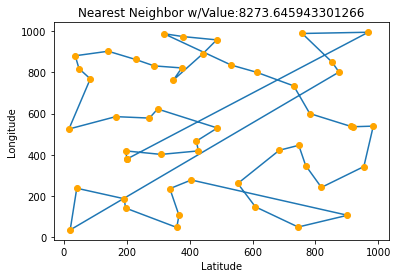

In [67]:
nearestNeighborX,nearestNeighborY = sortCitiesSolution(route)
fig,ax = plt.subplots()
plt.scatter(nearestNeighborX,nearestNeighborY ,color='orange',zorder=1)
plt.plot(nearestNeighborX,nearestNeighborY ,zorder=0)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
title = "Nearest Neighbor w/Value:" + str(total)
ax.set_title(title)
fig.savefig("nearestneighbor.png")
plt.show()

8132.931395688585


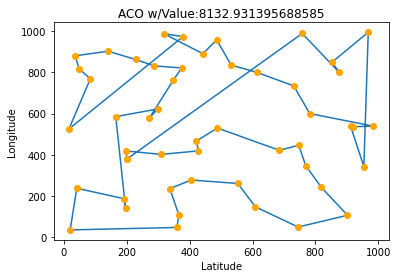

In [151]:
s_iter,total_list = aco_results()
acoX,acoY = sortCitiesSolution(s_iter)
fig,ax = plt.subplots()
plt.scatter(acoX,acoY,color='orange',zorder=1)
plt.plot(acoX,acoY,zorder=0)
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
title = "ACO w/Value:" + str(total_list)
ax.set_title(title)
fig.savefig("ACO.png")
plt.show()